In [1]:
import os
os.chdir("../")
%pwd

'/home/malik-harris/dental'

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd

class DentalImageDataset(Dataset):
    def __init__(self, csv_file, transform=None, kaggle=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.kaggle = kaggle
        if kaggle:
            self.base_path = "/kaggle/input/dental01"
        else:
            self.base_path = ""

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        if self.kaggle:
            img_path = os.path.join(self.base_path, os.path.relpath(img_path, "data"))
        image = Image.open(img_path).convert("RGB")
        label = int(self.data.iloc[idx]['label_encoded'])
        if self.transform:
            image = self.transform(image)
        return image, label

# Example transforms (add augmentation here if needed)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
])
train_csv = "data/Final_data/train_labels.csv"
val_csv = "data/Final_data/val_labels.csv"
test_csv = "data/Final_data/test_labels.csv"

train_dataset = DentalImageDataset(train_csv, transform=train_transform)
val_dataset = DentalImageDataset(val_csv, transform=val_test_transform)
test_dataset = DentalImageDataset(test_csv, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange


# Get number of classes from your dataset
num_classes = len(pd.read_csv(train_csv)["label_encoded"].unique())

# Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)


In [5]:
import torchmetrics
train_acc_metric = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='weighted').to(device)
val_acc_metric = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes, average='weighted').to(device)
train_f1_metric = torchmetrics.classification.MulticlassF1Score(num_classes=num_classes, average='weighted').to(device)
val_f1_metric = torchmetrics.classification.MulticlassF1Score(num_classes=num_classes, average='weighted').to(device)
train_precision_metric = torchmetrics.classification.MulticlassPrecision(num_classes=num_classes, average='weighted').to(device)
val_precision_metric = torchmetrics.classification.MulticlassPrecision(num_classes=num_classes, average='weighted').to(device)
train_recall_metric = torchmetrics.classification.MulticlassRecall(num_classes=num_classes, average='weighted').to(device)
val_recall_metric = torchmetrics.classification.MulticlassRecall(num_classes=num_classes, average='weighted').to(device)

Epochs: 100%|██████████| 1/1 [00:15<00:00, 15.35s/it]

Epoch 1/1 | Train Loss: 1.9028, Acc: 0.2548, F1: 0.2084, Prec: 0.2181, Rec: 0.2548 | Val Loss: 1.8216, Acc: 0.2984, F1: 0.2318, Prec: 0.2084, Rec: 0.2984
Best model saved at epoch 1 with val acc: 0.2984


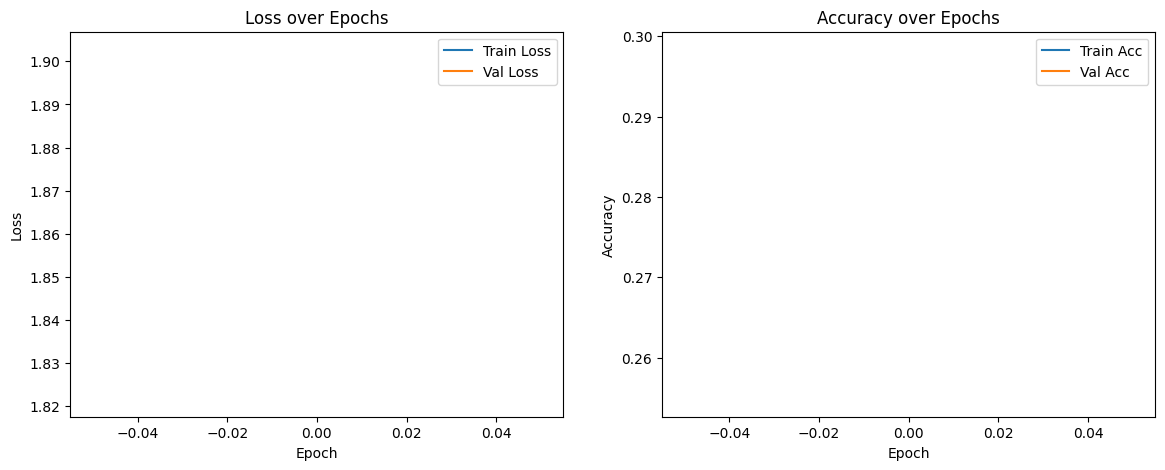

In [6]:
num_epochs = 1

model_dir = "Model"
best_val_acc = 0.0
os.makedirs(model_dir, exist_ok=True)
checkpoint_path = os.path.join(model_dir, "best_model.pth")
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1s, val_f1s = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []

for epoch in trange(num_epochs, desc="Epochs"):
    model.train()
    running_loss, total = 0.0, 0
    train_acc_metric.reset(), train_f1_metric.reset(), train_precision_metric.reset(), train_recall_metric.reset()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        train_acc_metric.update(preds, labels)
        train_f1_metric.update(preds, labels)
        train_precision_metric.update(preds, labels)
        train_recall_metric.update(preds, labels)
        total += labels.size(0)
    train_loss = running_loss / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc_metric.compute().item())
    train_f1s.append(train_f1_metric.compute().item())
    train_precisions.append(train_precision_metric.compute().item())
    train_recalls.append(train_recall_metric.compute().item())

    # Validation
    model.eval()
    running_loss, total = 0.0, 0
    val_acc_metric.reset(), val_f1_metric.reset(), val_precision_metric.reset(), val_recall_metric.reset()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            val_acc_metric.update(preds, labels)
            val_f1_metric.update(preds, labels)
            val_precision_metric.update(preds, labels)
            val_recall_metric.update(preds, labels)
            total += labels.size(0)
    val_loss = running_loss / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc_metric.compute().item())
    val_f1s.append(val_f1_metric.compute().item())
    val_precisions.append(val_precision_metric.compute().item())
    val_recalls.append(val_recall_metric.compute().item())

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_accuracies[-1]:.4f}, F1: {train_f1s[-1]:.4f}, "
          f"Prec: {train_precisions[-1]:.4f}, Rec: {train_recalls[-1]:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_accuracies[-1]:.4f}, F1: {val_f1s[-1]:.4f}, "
          f"Prec: {val_precisions[-1]:.4f}, Rec: {val_recalls[-1]:.4f}")

    # Save best model
    if val_accuracies[-1] > best_val_acc:
        best_val_acc = val_accuracies[-1]
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Best model saved at epoch {epoch+1} with val acc: {val_accuracies[-1]:.4f}")

# Plot loss and accuracy
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)
plt.savefig(os.path.join(plots_dir, "training_curves.png"))
plt.show()


Best model was saved at epoch 1
Train Loss at best epoch: 1.9028
Val Loss at best epoch: 1.8216
Train Accuracy at best epoch: 0.2548
Val Accuracy at best epoch: 0.2984


<Figure size 1000x800 with 0 Axes>

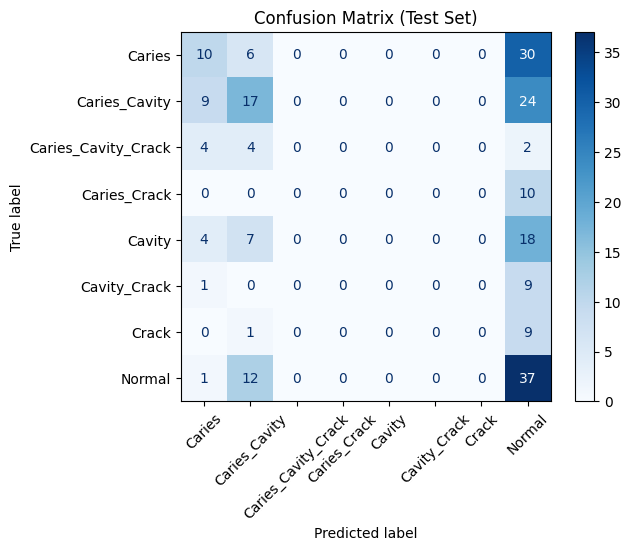

Classification Report (Test Set):
                      precision    recall  f1-score   support

             Caries       0.34      0.22      0.27        46
      Caries_Cavity       0.36      0.34      0.35        50
Caries_Cavity_Crack       0.00      0.00      0.00        10
       Caries_Crack       0.00      0.00      0.00        10
             Cavity       0.00      0.00      0.00        29
       Cavity_Crack       0.00      0.00      0.00        10
              Crack       0.00      0.00      0.00        10
             Normal       0.27      0.74      0.39        50

           accuracy                           0.30       215
          macro avg       0.12      0.16      0.13       215
       weighted avg       0.22      0.30      0.23       215



/home/malik-harris/anaconda3/envs/dental/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/malik-harris/anaconda3/envs/dental/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/malik-harris/anaconda3/envs/dental/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [8]:
# Load the best model
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix


model.load_state_dict(torch.load(os.path.join(model_dir, "best_model.pth")))
model.eval()
best_epoch = val_accuracies.index(max(val_accuracies))
print(f"\nBest model was saved at epoch {best_epoch+1}")
print(f"Train Loss at best epoch: {train_losses[best_epoch]:.4f}")
print(f"Val Loss at best epoch: {val_losses[best_epoch]:.4f}")
print(f"Train Accuracy at best epoch: {train_accuracies[best_epoch]:.4f}")
print(f"Val Accuracy at best epoch: {val_accuracies[best_epoch]:.4f}")

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get class names
class_encoding = pd.read_csv("data/Final_data/class_encoding.csv")
class_names = class_encoding.sort_values("label_encoded")["class"].tolist()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.savefig(os.path.join(plots_dir, "confusion_matrix_test.png"))
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report (Test Set):\n", report)


In [13]:
from sklearn.metrics import classification_report
import pandas as pd

# ...existing code to get all_preds and all_labels...

# Get class names
class_encoding = pd.read_csv("data/Final_data/class_encoding.csv")
class_names = class_encoding.sort_values("label_encoded")["class"].tolist()

# Generate classification report as a dict
report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

# Convert to DataFrame and round to 2 decimals
report_df = pd.DataFrame(report_dict).transpose().round(2)

# Save to CSV
report_df.to_csv(os.path.join(plots_dir, "classification_report_test.csv"))
print(f"Classification report saved to {os.path.join(plots_dir, 'classification_report_test.csv')}")

# (Optional) Also print the report in text format
print("Classification Report (Test Set):\n", classification_report(all_labels, all_preds, target_names=class_names))

Classification report saved to plots/classification_report_test.csv
Classification Report (Test Set):
                      precision    recall  f1-score   support

             Caries       0.34      0.22      0.27        46
      Caries_Cavity       0.36      0.34      0.35        50
Caries_Cavity_Crack       0.00      0.00      0.00        10
       Caries_Crack       0.00      0.00      0.00        10
             Cavity       0.00      0.00      0.00        29
       Cavity_Crack       0.00      0.00      0.00        10
              Crack       0.00      0.00      0.00        10
             Normal       0.27      0.74      0.39        50

           accuracy                           0.30       215
          macro avg       0.12      0.16      0.13       215
       weighted avg       0.22      0.30      0.23       215



/home/malik-harris/anaconda3/envs/dental/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/malik-harris/anaconda3/envs/dental/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/malik-harris/anaconda3/envs/dental/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [14]:
# ...existing code to get all_preds and all_labels...

from sklearn.metrics import classification_report
import pandas as pd

# Get class names
class_encoding = pd.read_csv("data/Final_data/class_encoding.csv")
class_names = class_encoding.sort_values("label_encoded")["class"].tolist()

# Generate the text report
report_text = classification_report(all_labels, all_preds, target_names=class_names, digits=2)

# Save the text report to a file
with open(os.path.join(plots_dir, "classification_report_test.txt"), "w") as f:
    f.write("Classification Report (Test Set):\n")
    f.write(report_text)

print(f"Classification report saved to {os.path.join(plots_dir, 'classification_report_test.txt')}")

Classification report saved to plots/classification_report_test.txt


/home/malik-harris/anaconda3/envs/dental/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/malik-harris/anaconda3/envs/dental/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/malik-harris/anaconda3/envs/dental/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f